# 02 - Pull out reusable code, Standardize & Winsorize features

In [2]:
import sys
import sys
import numpy as np
import polars as pl
sys.path.append('../pipeline')
from dataset import CSVDataset, KaggleDataset
from evaluate import Evaluator


In [6]:
# kaggle_dataset = KaggleDataset()
# kaggle_dataset.load()

In [3]:
dataset = CSVDataset('../data/',["articles.csv","transactions_train.csv","customers.csv"])
dataset.load()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv



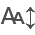

t_dat,customer_id,article_id,price,sales_channel_id
date,str,str,f64,i64
2018-09-20,"""000058a12d5b43e67d225668fa1f8d…","""0663713001""",0.050831,2


In [14]:
query = '''
    SELECT *
    FROM transactions
    LIMIT 1
'''

swallow = dataset.run_query_display_results(query)

In [4]:
from datetime import date, timedelta

# Eventually I will be creating complex features so query will likely be generated
# and then there will be windows of responses and features as well
# I'm undecided at this point so I might simply put this in a class with three methods
# one to get features, one to get label, and one to get backtest

class QueryConstants:
    end_date=date(2020,9,22)
    feature_duration=365
    label_duration=30
    backtest_duration=30
    label_end =  end_date - timedelta(days=backtest_duration)
    feature_end = label_end - timedelta(days=label_duration)
    feature_start = feature_end - timedelta(days=feature_duration)

response_query = """
        SELECT
            t.customer_id,
            MAX(
                CASE
                    WHEN t.t_dat > DATE '{response_start}'  AND t.t_dat <= DATE '{response_end}'  THEN 1
                    ELSE 0
                END
            ) AS label
        FROM transactions t
        INNER JOIN customers c ON c.customer_id = t.customer_id
        GROUP BY t.customer_id
"""

feature_query = """
            SELECT
                t.customer_id
                ,COUNT(1) total_transaction_items
                ,DATE '{feature_end}' - MAX(t.t_dat) as days_since_last
                ,ROUND(590*SUM(price)) as total_revenue --See Kaggle compition news group regarding the 590 factor - todo: get link
                ,COUNT(DISTINCT t.t_dat) as total_transactions
            FROM transactions t
            WHERE t.t_dat <= DATE '{feature_end}' and t.t_dat > DATE '{feature_start}'
            GROUP BY t.customer_id
"""

label_query = response_query.format(response_start=QueryConstants.feature_end, response_end=QueryConstants.label_end)
backtest_response_query = response_query.format(response_start=QueryConstants.label_end, response_end=QueryConstants.end_date)

arrow_table = dataset.duckdb_conn.execute(label_query).fetch_arrow_table()
label_df = pl.from_arrow(arrow_table)

arrow_table = dataset.duckdb_conn.execute(label_query).fetch_arrow_table()
backtest_response_df = pl.from_arrow(arrow_table)

query = feature_query.format(**vars(QueryConstants))
arrow_table = dataset.duckdb_conn.execute(query).fetch_arrow_table()
feature_df = pl.from_arrow(arrow_table)



In [5]:
# training - cut and paste for now

import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# Align DataFrames on "id"
aligned_df = feature_df.join(label_df, on="customer_id")

# Automatically separate features and labels
excluded_columns = ["customer_id", "label"]  # Columns to exclude
feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]

# Split into features (X) and labels (y)
X = aligned_df.select(feature_columns).to_numpy()
y = aligned_df["label"].to_numpy()

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(type(X_train))
print(X_train.shape)

# model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)

# Compute AUC for training set
y_train_prob = model.predict_proba(X_train)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train, y_train_prob)





<class 'numpy.ndarray'>
(787288, 4)


Computing optimal Threshold: 0.27
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.27
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.88      0.78      0.83    614125
           1       0.45      0.63      0.52    173163

    accuracy                           0.75    787288
   macro avg       0.67      0.71      0.68    787288
weighted avg       0.79      0.75      0.76    787288



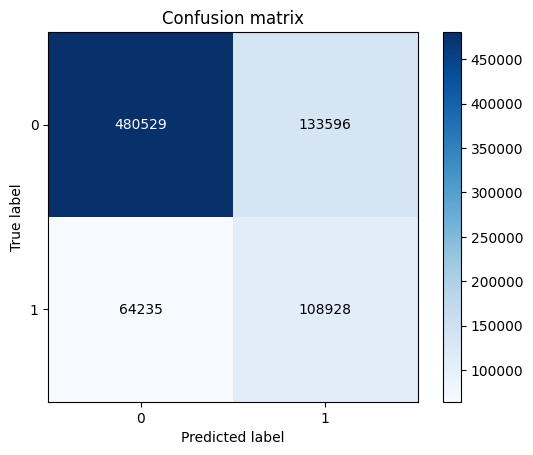

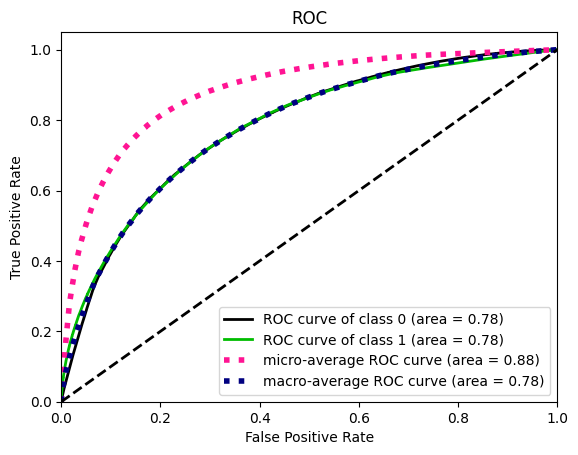

In [6]:
e_train = Evaluator(y_train, y_train_prob)
e_train.display_results()

In [7]:
# score the test

y_test_prob_both = model.predict_proba(X_test)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

Computing optimal Threshold: 0.27
Computing predictions...
AUC: 0.78
Optimal Threshold: 0.27
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.88      0.78      0.83    153531
           1       0.45      0.63      0.52     43291

    accuracy                           0.75    196822
   macro avg       0.67      0.71      0.68    196822
weighted avg       0.79      0.75      0.76    196822



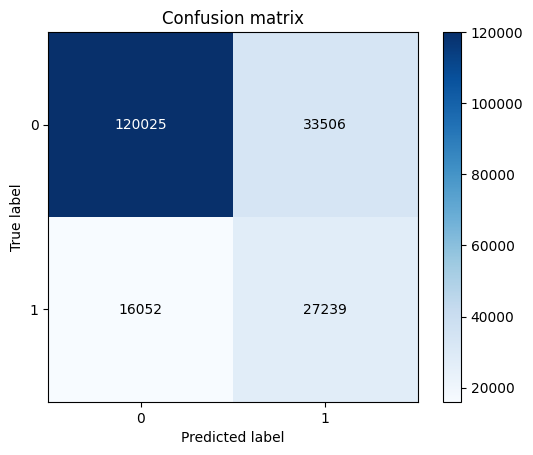

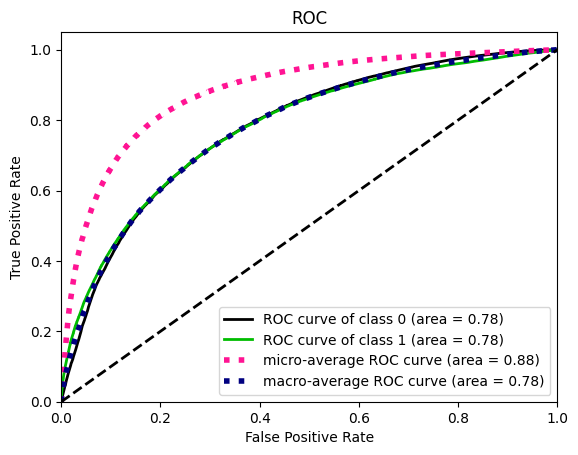

In [8]:
e_test = Evaluator(y_test, y_test_prob_both)
e_test.display_results()



feature_start:  2019-08-24
feature_end:  2020-08-23
(985282, 5)
(985282, 4)
Computing predictions...
AUC: 0.85
Optimal Threshold: 0.27
Maximum F1 Score: 0.61
              precision    recall  f1-score   support

           0       0.88      0.82      0.85    738856
           1       0.56      0.68      0.61    246426

    accuracy                           0.79    985282
   macro avg       0.72      0.75      0.73    985282
weighted avg       0.80      0.79      0.79    985282




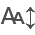

decile,buyer_count,scored_customer_count,non_buyer_count
i64,"decimal[38,0]",i64,"decimal[38,0]"
10,4816,98528,93712
9,5442,98528,93086
8,6800,98528,91728
7,10028,98528,88500
6,13079,98528,85449
5,17870,98528,80658
4,23018,98528,75510
3,30024,98528,68504
2,40039,98529,58490


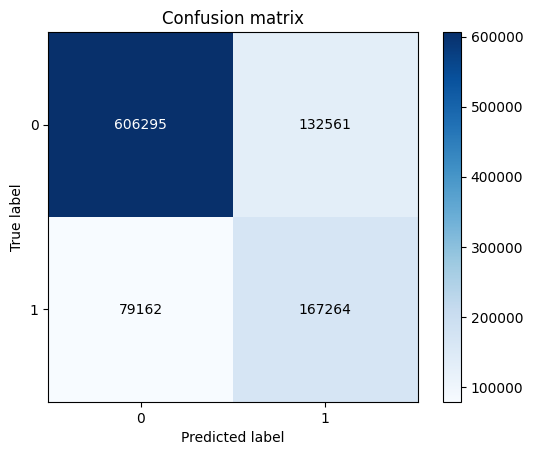

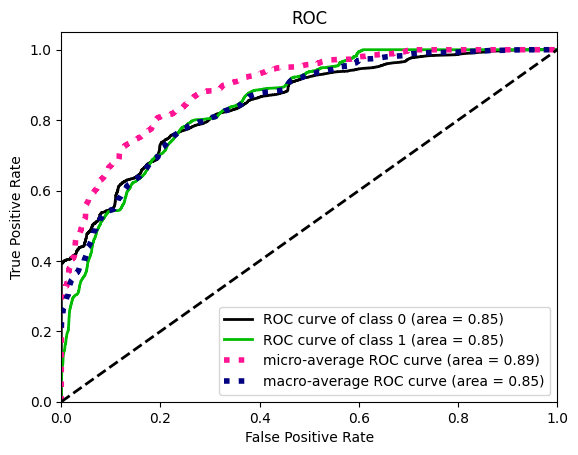

In [23]:

end_date = date(2020,9,22)
feature_duration = 365
backtest_duration = 30
label_duration = 0
label_end =  end_date - timedelta(days=backtest_duration)
feature_end = label_end - timedelta(days=label_duration)
feature_start = feature_end - timedelta(days=feature_duration)

print("feature_start: ", feature_start)
print("feature_end: ", feature_end)

backtest_feature_query = feature_query.format(feature_end=feature_end, feature_start=feature_start)
arrow_table = dataset.duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()

backtest_feature_df = pl.from_arrow(arrow_table)

dataset.duckdb_conn.register("backtest_features", backtest_feature_df)

print(backtest_feature_df.shape)

features_without_id = backtest_feature_df.drop("customer_id")

print(features_without_id.shape)

scores_prob_positive = model.predict_proba(features_without_id.to_numpy())[:, 1]
backtest_pred = [1 if prob >= e_test.optimal_threshold else 0 for prob in scores_prob_positive]

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_prob_positive,
    "prediction": backtest_pred
})

dataset.duckdb_conn.register("scores", scores_df)

backtest_pred_truth_df = scores_df.join(backtest_response_df, on="customer_id")
backtest_response = np.array(backtest_pred_truth_df["label"])
backtest_score = np.array(backtest_pred_truth_df["score"])

e_backtest = Evaluator(backtest_response, backtest_score, threshold=e_test.optimal_threshold)

e_backtest.display_results()

query = f'''

SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
FROM (
    SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, COALESCE(bought,0) as bought
    from scores s
    left outer join (
        SELECT customer_id, COUNT(distinct t.customer_id) bought
        from transactions t
        WHERE t_dat > DATE '{feature_end}'
        GROUP BY customer_id
    ) t on t.customer_id = s.customer_id
    GROUP BY s.customer_id, score, bought
) x
GROUP BY decile
ORDER BY decile DESC
'''

backtest_results = dataset.run_query_display_results(query)
# backtest - use the new features and labels code I think firstly
# scoring ... leave this open for now

# I can use the feature query constant and set the correct parameters to get the backtest features


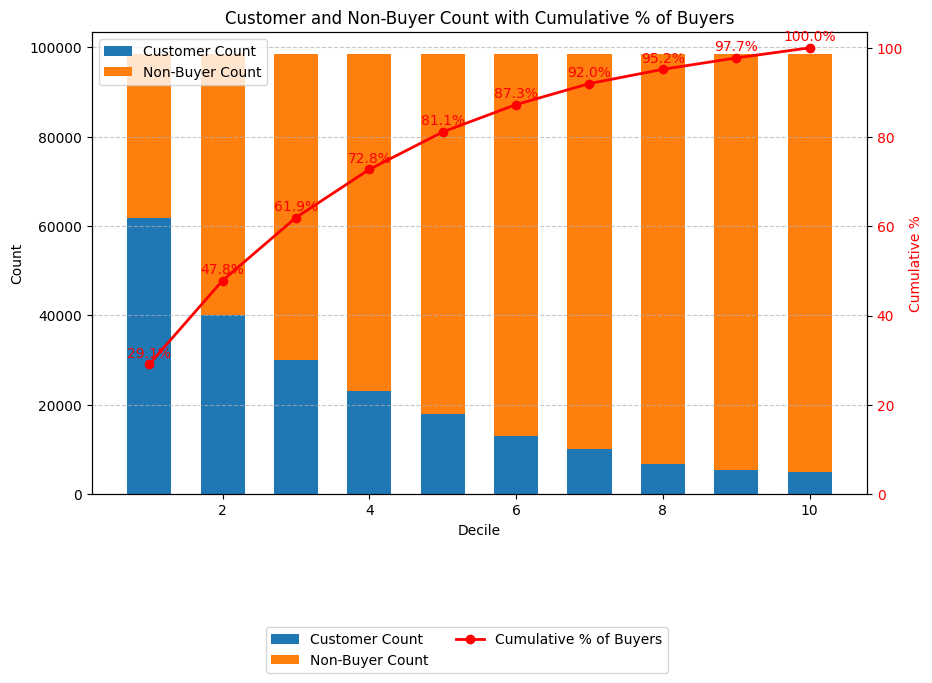

In [24]:


# plot the response curve ... put into a class
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being

Optimal Threshold: 0.5
Computing predictions...
AUC: 0.83
Optimal Threshold: 0.5
Maximum F1 Score: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



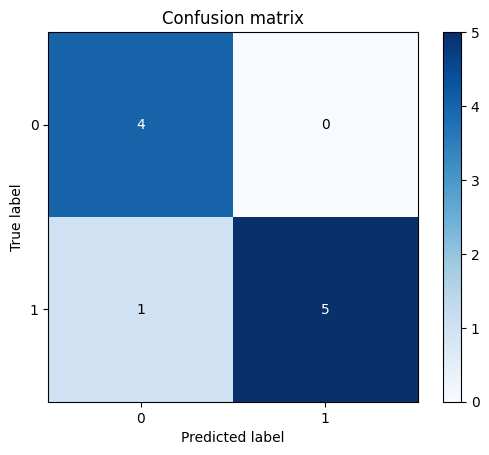

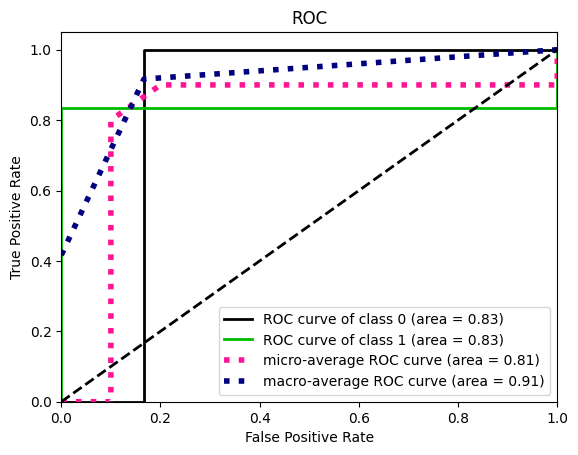

In [12]:

sys.path.append('../pipeline')

y_true = np.array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1])
y_pred_proba = np.array([0.1, 0.8, 0.3, 0.7, 0.5, 0.2, 0.6, 0.4, 0.9, 0.05])
e = Evaluator(y_true, y_pred_proba)
e.display_results()

[[0.9  0.1 ]
 [0.2  0.8 ]
 [0.7  0.3 ]
 [0.3  0.7 ]
 [0.5  0.5 ]
 [0.8  0.2 ]
 [0.4  0.6 ]
 [0.6  0.4 ]
 [0.1  0.9 ]
 [0.95 0.05]]
Optimal Threshold: 0.5
Computing predictions...
AUC: 0.83
Optimal Threshold: 0.5
Maximum F1 Score: 0.9090909090909091
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



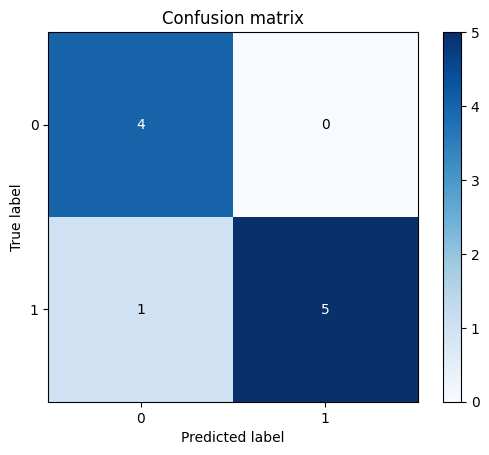

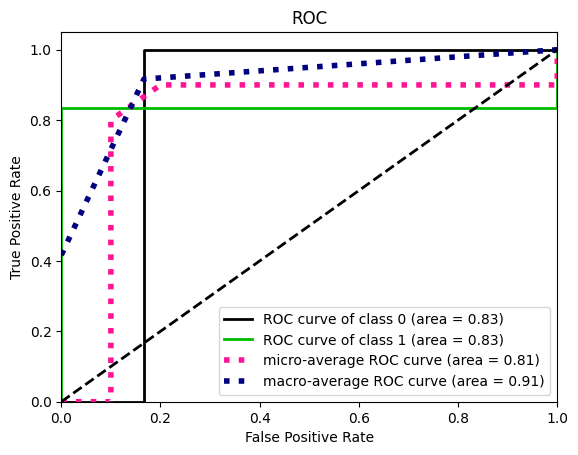

In [13]:
import sys
import numpy as np
sys.path.append('../pipeline')
from evaluate import Evaluator

y_true = np.array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1])

y_pred_proba = np.array([0.1, 0.8, 0.3, 0.7, 0.5, 0.2, 0.6, 0.4, 0.9, 0.05])
y_pred_neg = 1 - y_pred_proba

probabilities = np.stack((y_pred_neg, y_pred_proba), axis=1)
print(probabilities)

e = Evaluator(y_true, probabilities)
e.display_results()